TODO: 
- (done) implement fastrcnn (and other pl lightning detection models?) in trajectory extractor
- get grand central station (done) and football stadium (TODO) data working 

# Import Packages

In [1]:
## download ckpt.t7 from
# https://drive.google.com/drive/folders/1xhG0kRH1EX5B9_Iz8gQJb7UNnn_riXi6
# to deep_sort/deep/checkpoint

In [2]:
# !wget https://raw.githubusercontent.com/AlexeyAB/darknet/master/cfg/yolov4-tiny-3l.cfg
# !wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.weights
# !git clone https://github.com/JonathonLuiten/TrackEval

In [124]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [125]:
import pandas as pd 
import numpy as np
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import cv2, glob, os, torch, math, torchvision, datetime
from pl_bolts.models.detection import YOLO, YOLOConfiguration
from tqdm.notebook import tqdm 
import utm

# my files
from deep_sort.deep_sort import DeepSort
import draw_utils, transform_utils
from trajectory_extractor import TrajectoryExtractor

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Defined User Args

In [131]:
# other videos
class TrajectoryExtractorArgs: 
    detector_name = 'YOLO'
    tracker_name = 'DeepSORT'
    
    unique_suffix = str(datetime.datetime.now().date()) + '_' + str(datetime.datetime.now().time()).replace(':', '.')
#     input_video_path = "videos/Stadium/00084.wmv"
#     input_video_path = "videos/Y2E2/Y2E2_West.MOV"
#     input_video_path = "videos/GCS/grandcentral.avi" # cannot use because no gt. fml.
    input_video_path = "videos/GCS/slideshow.avi" # Use this for paper YOLO. 
#     input_video_path = "videos/GCS/slideshow_small.avi" # Use this for paper FRCNN. 
    
    output_txt_folder = 'TrackEval/data/trackers/mot_challenge/GCS-val/{}_{}_{}'.format(detector_name, tracker_name, unique_suffix)
    if not os.path.exists(output_txt_folder):
        os.makedirs(output_txt_folder)
        os.makedirs(output_txt_folder+'/data')
    output_txt_path = output_txt_folder+'/data/seq-01.txt'
    args_save_txt_path = output_txt_folder+'/args.txt'
    output_video_path = os.path.split(input_video_path)[0]+"/out/{}.avi".format(unique_suffix)
    
#     yolo_config_path = "yolo/yolov4-tiny-3l.cfg"
#     yolo_pre_weights_path = "yolo/yolov4-tiny.weights"
    yolo_config_path = "yolo/yolov7-tiny.cfg"
    yolo_pre_weights_path = "yolo/yolov7-tiny.weights"

    confidence_threshold = 0.01 #YOLO: 0.01 GCS, 0.7 Y2E2; FRCNN: 0.01 GCS, 0.68 Y2E2
    deepsort_parameters_path = "deep_sort/deep/checkpoint/ckpt.t7"
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
args = TrajectoryExtractorArgs

In [132]:
args.output_txt_path, args.output_video_path

('TrackEval/data/trackers/mot_challenge/GCS-val/YOLO_DeepSORT_2022-11-27_21.35.47.958858/data/seq-01.txt',
 'videos/GCS/out_2022-11-27_21.35.47.958858.avi')

# Step 1: DL model to track human locations in frames

In [133]:
# set up our extractor
extractor = TrajectoryExtractor(args)

##################################################
if args.detector_name == 'YOLO':
    # set up yolo
    yolo_config = YOLOConfiguration(args.yolo_config_path)
    yolo_config.width = extractor.imw
    yolo_config.height = extractor.imh
    model = YOLO(network=yolo_config.get_network()).to(device)
    with open(args.yolo_pre_weights_path) as pre_weights: 
        model.load_darknet_weights(pre_weights)

    extractor.load_detector(model)

##################################################
elif args.detector_name == 'FasterRCNN':
    # set up faster rcnn
    
    # implemented to add the "infer" function to infer on single image 
    anchor_generator = torchvision.models.detection.anchor_utils.AnchorGenerator(sizes=((8, 16, 32, 64, 128),),
                                                                                 aspect_ratios=((0.5, 1.0),))
    class modified_FasterRCNN(torch.nn.Module): 
        def __init__(self, **kwargs):
            super().__init__()
            self.model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(**kwargs)
        def infer(self, rgb_tensor): 
            # single image
            pred_dict = self.model([rgb_tensor])[0]
            boxes = pred_dict['boxes'] # (N,4)
            labels = pred_dict['labels'] # (N)
            labels = [l - 1 for l in labels] # subtract 1 from class IDs because coco classes have background=0. person=1
            confidences = pred_dict['scores'] # (N)  
            num_boxes = boxes.shape[0]
            
            return boxes, confidences, labels
    
#     model = modified_FasterRCNN(weights='DEFAULT', 
#                                 weights_backbone = 'DEFAULT',
#                                 box_score_thresh=args.confidence_threshold, 
#                                 box_nms_thresh=0.1,
#                                 box_detections_per_img=300,
#                                ).to(device)
    model = modified_FasterRCNN(weights='DEFAULT').to(device)
    extractor.load_detector(model)

##################################################
if args.tracker_name == 'DeepSORT':
    # set up deepsort
    extractor.load_tracker(
        DeepSort(args.deepsort_parameters_path, 
                 min_confidence = args.confidence_threshold,
                 max_dist = 1e10, 
                 max_iou_distance = 0.999, 
                 max_age = 4,
#                  nms_max_overlap=1000
                )
    )

elif args.tracker_name == 'SORT': 
    # TODO
    pass

detector_out_df, tracker_out_df, txt_df = extractor.detect_all(
    max_frames=50,
    skip_every_n_frames = 1
)

extractor.release_all()

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


Loading video from videos/GCS/slideshow.avi...
1
Loaded video has 6001 frames at FPS 1, size 1920x1080
transformed to size 1920x1088


100%|███████████████████████████████████████████| 50/50 [00:08<00:00,  5.94it/s]


In [134]:
len(detector_out_df.query('frame_number==30'))

71

In [135]:
len(tracker_out_df.query('frame_number==30'))

61

In [136]:
txt_df.head(5)

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,person_id,crowd_count,frame_number,bbox_w,bbox_h,conf,x,y,z
0,1201,254,1215,282,3,40,3,0,0,1,-1,-1,-1
1,1446,376,1457,407,6,40,3,0,0,1,-1,-1,-1
2,424,508,437,545,8,40,3,0,0,1,-1,-1,-1
3,886,684,899,721,10,40,3,0,0,1,-1,-1,-1
4,608,270,621,298,12,40,3,0,0,1,-1,-1,-1


<AxesSubplot: >

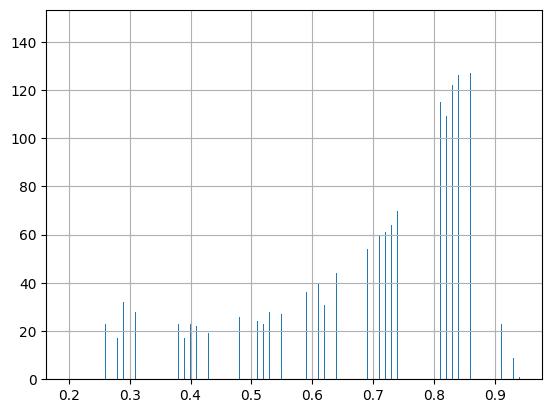

In [82]:
detector_out_df['confidence'].hist(bins=1000)

In [83]:
tracker_out_df.head(-5)

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,person_id,crowd_count,frame_number
0,1188,226,1216,282,3,39,3
1,1435,346,1456,407,6,39,3
2,411,474,436,546,8,39,3
3,874,648,899,721,10,39,3
4,597,242,621,298,12,39,3
...,...,...,...,...,...,...,...
42,1501,284,1516,312,856,52,50
43,409,328,438,394,858,52,50
44,1537,412,1561,472,860,52,50
45,709,686,732,747,868,52,50


# Step 2: Obtain 2D Plane Projection （TODO: automate this)

In [ ]:
# precomputed homography matrices
############# STADIUM #############
# pts_img = [[450.0,203.0],[282.0,297.0],[470.0,403.0],[630.0,270.0]] # top left, bot left, bot right, top right 
# pts_world = [[250,250], [250,500], [500,500],[500,250]]

# HOMOG, status = cv2.findHomography(np.array(pts_img), np.array(pts_world)+700)

############# GCS #############
# HOMOG = [[4.97412897e-02, -4.24730883e-02, 7.25543911e+01],
#          [1.45017874e-01, -3.35678711e-03, 7.97920970e+00],
#          [1.36068797e-03, -4.98339188e-05, 1.00000000e+00]] 

############# Y2E2 West #############
#note: points must be consistent in order and winding (e.g. clockwise) 
pts_img = [[1090, 1625], [2270, 1785], [2010, 2250], [470, 2150]] # palm tree locations 
long_lat_world = [(37.428570, -122.175184), (37.428489, -122.175211), 
                  (37.428506, -122.175288), (37.428589, -122.175260)]
pts_world = []
for lat,lon in long_lat_world: 
    utm_east, utm_north, utm_zone, utm_letter = utm.from_latlon(lat,lon) # meters
    pts_world.append([utm_east*100, utm_north*100]) # centimeters
# shift pts_world so that values aren't too big
world_np = np.array(pts_world)
world_np = world_np - world_np.min(axis=0)
pts_world = world_np.tolist()

    
HOMOG, status = cv2.findHomography(np.array(pts_img), np.array(pts_world))

In [10]:
HOMOG

array([[-1.35182588e-01, -1.66664049e+00,  4.02165809e+03],
       [-9.68577484e-01, -3.90567691e-02,  2.26838722e+03],
       [-2.04737711e-04,  3.07059869e-04,  1.00000000e+00]])

# Step 3: Obtain the transformed human trajectories in world coordinates

In [11]:
#### converting any coordinate to world coordinate 
def img_to_world_coords(coords_img, HOMOG, pts_img = None, pts_world = None):
    '''
    use at least 4 
    input: 
        coords_img: a np array of dim (num_ped,seq_len,2)
    if using pre-computed HOMOG, no need to use pts_img and pts_world
        pts_img: a list of [x,y] points in image coordinates. list length cannot be shorter than 4
        pts_world: a list of [x,y] points in world coordinates. each point cooresponds to a point in pts_img
        assumed_height: the estimated height of all humans. source: https://www.sciencedirect.com/science/article/pii/S0379073811002167
                        NOT USED FOR NOW 
    output: 
        coords_world: same shape as coords_img but in world coordinates
    '''
    # convert to np matrix and check size
    if pts_img == None: 
        h = HOMOG
    else: 
        pts_img = np.array(pts_img)
        pts_world = np.array(pts_world)
        assert pts_img.shape==pts_world.shape and pts_img.shape[0] >= 4
     
        # calculate homography matrix H. more pts_img means more accurate H
        h, status = cv2.findHomography(pts_img, pts_world)
     
    # finally, get the mapped world coordinates
    coords_world = cv2.perspectiveTransform(coords_img.astype(np.float32), h)
    # coords_world[:,1] += assumed_height
    return coords_world

In [12]:
x1y2x2y2 = pedestrian_df[[ 'bbox_x1', 
                           'bbox_y2',
                           'bbox_x2', 
                           'bbox_y2', ]].values.reshape(-1,2,2)

In [13]:
pedestrian_df[['mapped_x1', 
               'mapped_y1']] = img_to_world_coords(x1y2x2y2, HOMOG)[:,0,:]
pedestrian_df[['mapped_x2', 
               'mapped_y2']] = img_to_world_coords(x1y2x2y2, HOMOG)[:,1,:]

In [14]:
pedestrian_df

,person_id,confidence,bbox_x1,bbox_y1,bbox_x2,bbox_y2,frame_number,mapped_x1,mapped_y1,mapped_x2,mapped_y2
0,0,0.99,155,82,252,369,0,3130.367920,1945.176270,3176.571777,1893.070190
1,1,0.98,286,22,386,195,0,3653.172607,1981.139526,3715.645020,1923.743896
2,2,0.98,460,89,568,384,0,3242.533447,1765.935181,3299.539307,1700.482666
3,3,0.95,540,75,635,312,0,3480.017822,1759.126831,3536.804443,1699.280029
4,4,0.95,307,-13,360,225,0,3582.827637,1950.089355,3614.687744,1919.775391
...,...,...,...,...,...,...,...,...,...,...,...
3,3,0.87,518,110,581,260,99,3613.035645,1803.802490,3652.672119,1764.511475
4,4,0.79,292,11,335,252,99,3500.595947,1941.557251,3525.383545,1917.215332
5,5,0.75,266,36,358,230,99,3545.071289,1969.921631,3599.554688,1917.778320
6,6,0.74,662,82,751,398,99,3312.995117,1633.412109,3362.906738,1575.133545


<AxesSubplot: xlabel='mapped_x1', ylabel='mapped_y1'>

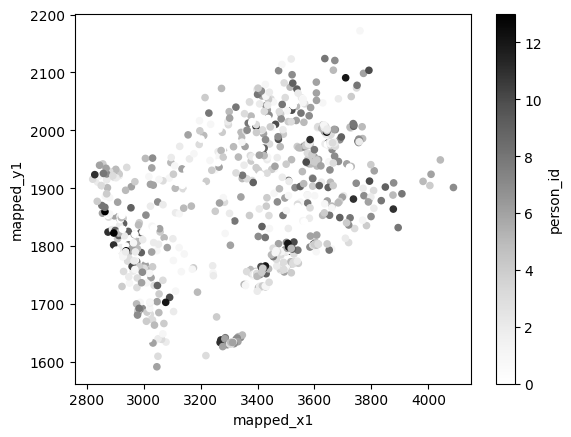

In [15]:
pedestrian_df.plot.scatter('mapped_x1', 'mapped_y1', c='person_id')

# Step 4: Identify crowdedness severity

In [16]:
for ii, df in pedestrian_df.groupby('frame_number'): 
    

SyntaxError: incomplete input (2874010739.py, line 2)

In [ ]:
# density heatmap 
x,y = (pedestrian_df[['mapped_x1', 'mapped_y1']].values[:,0],
       pedestrian_df[['mapped_x1', 'mapped_y1']].values[:,1])
heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

# Evaluation (Converting to MOTS challenge format)
The file format should be the same as the ground truth file, which is a CSV text-file containing one object instance per line. Each line must contain 10 values:

```
<frame>, <id>, <bb_left>, <bb_top>, <bb_width>, <bb_height>, <conf>, <x>, <y>, <z>
```
The conf value contains the detection confidence in the det.txt files. For the ground truth, it acts as a flag whether the entry is to be considered. A value of 0 means that this particular instance is ignored in the evaluation, while any other value can be used to mark it as active. For submitted results, all lines in the .txt file are considered. The world coordinates x,y,z are ignored for the 2D challenge and can be filled with -1. Similarly, the bounding boxes are ignored for the 3D challenge. However, each line is still required to contain 10 values.

All frame numbers, target IDs and bounding boxes are 1-based. Here is an example:
```
Tracking with bounding boxes
(MOT15, MOT16, MOT17, MOT20)
  1, 3, 794.27, 247.59, 71.245, 174.88, -1, -1, -1, -1
  1, 6, 1648.1, 119.61, 66.504, 163.24, -1, -1, -1, -1
  1, 8, 875.49, 399.98, 95.303, 233.93, -1, -1, -1, -1
  ...
```

In [16]:
tracker_out_df.head(1)

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,person_id,crowd_count,frame_number
0,353,420,392,524,1,68,2


In [18]:
txt_df = tracker_out_df.copy()
txt_df['bbox_w'] = txt_df['bbox_x2'] - txt_df['bbox_x1']
txt_df['bbox_h'] = txt_df['bbox_y2'] - txt_df['bbox_y1']
txt_df['conf'] = 1
txt_df['x'] = -1
txt_df['y'] = -1
txt_df['z'] = -1
txt_df[['frame_number', 'person_id', 'bbox_x1', 'bbox_y1', 'bbox_w', 'bbox_h', 'conf', 'x', 'y', 'z']].head(1)

,frame_number,person_id,bbox_x1,bbox_y1,bbox_w,bbox_h,conf,x,y,z
0,2,1,353,420,39,104,1,-1,-1,-1


In [20]:
txt_df[['frame_number', 'person_id', 'bbox_x1', 'bbox_y1', 'bbox_w', 'bbox_h', 'conf', 'x', 'y', 'z']].to_csv(args.output_txt_path, 
                                                                                                              header=None, 
                                                                                                              index=None, 
                                                                                                              sep=',', 
                                                                                                              mode='w')

In [21]:
args.output_txt_path

'videos/MOT20/train/MOT20-03/img1/out_2022-10-24_17.17.22.182574.txt'

# yolov7 tiny + deepsort params explore

In [ ]:
# for conf_thres in [0.01, 0.1, 0.2, 0.3, 0.5, 0.7]: 
#     for max_cos_dist in [0.05, 0.1, 0.2, 0.5]: 
#         for max_iou_dist in [0.3, 0.5, 0.7]: 
#             print('################')
#             print('conf_thres, max_cos_dist, max_iou_dist')
#             print(conf_thres, max_cos_dist, max_iou_dist)
#             #### args ###
#             class TrajectoryExtractorArgs: 
#                 unique_suffix = str(datetime.datetime.now().date()) + '_' + str(datetime.datetime.now().time()).replace(':', '.')
#             #     input_video_path = "videos/Stadium/00084.wmv"
#             #     input_video_path = "videos/Y2E2/Y2E2_West.MOV"
#             #     input_video_path = "videos/GCS/grandcentral.avi"
#                 MOT_subset_name = 'MOT20-05'
#                 input_video_path = "videos/MOT20/train/{}/img1/%06d.jpg".format(MOT_subset_name)
#             #     output_txt_path = output_video_path.replace("avi", "txt")

#                 output_txt_folder = 'TrackEval/data/trackers/mot_challenge/MOT20-train/YOLO_DeepSORT_{}'.format(unique_suffix)
#                 if not os.path.exists(output_txt_folder):
#                     os.makedirs(output_txt_folder)
#                     os.makedirs(output_txt_folder+'/data')
#                 output_txt_path = output_txt_folder+'/data/{}.txt'.format(MOT_subset_name)
#                 output_video_path = os.path.split(input_video_path)[0]+"/out_{}.avi".format(unique_suffix)

#             #     yolo_config_path = "yolo/yolov4-tiny-3l.cfg"
#             #     yolo_pre_weights_path = "yolo/yolov4-tiny.weights"
#                 yolo_config_path = "yolo/yolov7-tiny.cfg"
#                 yolo_pre_weights_path = "yolo/yolov7-tiny.weights"

#                 confidence_threshold = 0.01#0.7
#                 deepsort_parameters_path = "deep_sort/deep/checkpoint/ckpt.t7"

#             args = TrajectoryExtractorArgs
#             args.confidence_threshold = conf_thres
#             print(args.unique_suffix)
#             # set up our extractor
#             extractor = TrajectoryExtractor(args)

#             # set up yolo
#             yolo_config = YOLOConfiguration(args.yolo_config_path)
#             yolo_config.width = extractor.imw
#             yolo_config.height = extractor.imh
#             model = YOLO(network=yolo_config.get_network()).to(device)
#             with open(args.yolo_pre_weights_path) as pre_weights: 
#                 model.load_darknet_weights(pre_weights)

#             extractor.load_detector(model)

#             # # set up faster rcnn TODO
#             # model = FasterRCNN(pretrained=True).to(device)
#             # extractor.load_detector(model)

#             # set up deepsort
#             extractor.load_tracker(
#                 DeepSort(args.deepsort_parameters_path, 
#                          min_confidence = args.confidence_threshold, 
#                          max_dist=max_cos_dist,
#                          max_iou_distance=max_iou_dist)
#             )

#             detector_out_df, tracker_out_df = extractor.detect_all(
#             #     max_frames=100,
#                 skip_every_n_frames = 1
#             )

#             extractor.release_all()

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


################
conf_thres, max_cos_dist, max_iou_dist
0.01 0.05 0.3
2022-10-25_22.37.22.724378
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


  0%|          | 0/3315 [00:00<?, ?it/s]

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


################
conf_thres, max_cos_dist, max_iou_dist
0.01 0.05 0.5
2022-10-25_22.59.54.188765
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


  0%|          | 0/3315 [00:00<?, ?it/s]

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


################
conf_thres, max_cos_dist, max_iou_dist
0.01 0.05 0.7
2022-10-25_23.22.21.312317
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


  0%|          | 0/3315 [00:00<?, ?it/s]

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


################
conf_thres, max_cos_dist, max_iou_dist
0.01 0.1 0.3
2022-10-25_23.44.38.640396
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


  0%|          | 0/3315 [00:00<?, ?it/s]

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


################
conf_thres, max_cos_dist, max_iou_dist
0.01 0.1 0.5
2022-10-26_00.06.49.930444
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


  0%|          | 0/3315 [00:00<?, ?it/s]

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


################
conf_thres, max_cos_dist, max_iou_dist
0.01 0.1 0.7
2022-10-26_00.29.01.314908
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


  0%|          | 0/3315 [00:00<?, ?it/s]

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


################
conf_thres, max_cos_dist, max_iou_dist
0.01 0.2 0.3
2022-10-26_00.51.10.911551
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


  0%|          | 0/3315 [00:00<?, ?it/s]

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


################
conf_thres, max_cos_dist, max_iou_dist
0.01 0.2 0.5
2022-10-26_01.14.20.047720
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


  0%|          | 0/3315 [00:00<?, ?it/s]

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


################
conf_thres, max_cos_dist, max_iou_dist
0.01 0.2 0.7
2022-10-26_01.37.15.792533
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


  0%|          | 0/3315 [00:00<?, ?it/s]

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


################
conf_thres, max_cos_dist, max_iou_dist
0.01 0.5 0.3
2022-10-26_02.00.10.870584
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


  0%|          | 0/3315 [00:00<?, ?it/s]

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


################
conf_thres, max_cos_dist, max_iou_dist
0.01 0.5 0.5
2022-10-26_02.23.03.591107
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


  0%|          | 0/3315 [00:00<?, ?it/s]

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


################
conf_thres, max_cos_dist, max_iou_dist
0.01 0.5 0.7
2022-10-26_02.45.58.885229
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


  0%|          | 0/3315 [00:00<?, ?it/s]

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


################
conf_thres, max_cos_dist, max_iou_dist
0.1 0.05 0.3
2022-10-26_03.08.50.406674
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


  0%|          | 0/3315 [00:00<?, ?it/s]

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


################
conf_thres, max_cos_dist, max_iou_dist
0.1 0.05 0.5
2022-10-26_03.31.01.704861
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


  0%|          | 0/3315 [00:00<?, ?it/s]

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


################
conf_thres, max_cos_dist, max_iou_dist
0.1 0.05 0.7
2022-10-26_03.53.14.323985
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


  0%|          | 0/3315 [00:00<?, ?it/s]

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


################
conf_thres, max_cos_dist, max_iou_dist
0.1 0.1 0.3
2022-10-26_04.15.23.294726
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


  0%|          | 0/3315 [00:00<?, ?it/s]

################
conf_thres, max_cos_dist, max_iou_dist
0.1 0.1 0.5
2022-10-26_04.37.24.343860
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


  0%|          | 0/3315 [00:00<?, ?it/s]

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


################
conf_thres, max_cos_dist, max_iou_dist
0.1 0.1 0.7
2022-10-26_04.59.35.100344
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


  0%|          | 0/3315 [00:00<?, ?it/s]

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


################
conf_thres, max_cos_dist, max_iou_dist
0.1 0.2 0.3
2022-10-26_05.21.57.931876
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


  0%|          | 0/3315 [00:00<?, ?it/s]

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


################
conf_thres, max_cos_dist, max_iou_dist
0.1 0.2 0.5
2022-10-26_05.44.58.065156
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


  0%|          | 0/3315 [00:00<?, ?it/s]

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


################
conf_thres, max_cos_dist, max_iou_dist
0.1 0.2 0.7
2022-10-26_06.07.51.254285
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


  0%|          | 0/3315 [00:00<?, ?it/s]

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


################
conf_thres, max_cos_dist, max_iou_dist
0.1 0.5 0.3
2022-10-26_06.30.49.642891
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


  0%|          | 0/3315 [00:00<?, ?it/s]

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


################
conf_thres, max_cos_dist, max_iou_dist
0.1 0.5 0.5
2022-10-26_06.53.47.171536
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


  0%|          | 0/3315 [00:00<?, ?it/s]

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


################
conf_thres, max_cos_dist, max_iou_dist
0.1 0.5 0.7
2022-10-26_07.16.36.693588
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


  0%|          | 0/3315 [00:00<?, ?it/s]

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


################
conf_thres, max_cos_dist, max_iou_dist
0.2 0.05 0.3
2022-10-26_07.39.25.931527
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


  0%|          | 0/3315 [00:00<?, ?it/s]

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


################
conf_thres, max_cos_dist, max_iou_dist
0.2 0.05 0.5
2022-10-26_08.01.30.658049
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


  0%|          | 0/3315 [00:00<?, ?it/s]

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


################
conf_thres, max_cos_dist, max_iou_dist
0.2 0.05 0.7
2022-10-26_08.23.40.149176
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


  0%|          | 0/3315 [00:00<?, ?it/s]

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


################
conf_thres, max_cos_dist, max_iou_dist
0.2 0.1 0.3
2022-10-26_08.45.43.521093
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


  0%|          | 0/3315 [00:00<?, ?it/s]

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


################
conf_thres, max_cos_dist, max_iou_dist
0.2 0.1 0.5
2022-10-26_09.07.38.010194
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


  0%|          | 0/3315 [00:00<?, ?it/s]

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


################
conf_thres, max_cos_dist, max_iou_dist
0.2 0.1 0.7
2022-10-26_09.29.42.461803
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


  0%|          | 0/3315 [00:00<?, ?it/s]

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


################
conf_thres, max_cos_dist, max_iou_dist
0.2 0.2 0.3
2022-10-26_09.51.50.788709
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


  0%|          | 0/3315 [00:00<?, ?it/s]

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


################
conf_thres, max_cos_dist, max_iou_dist
0.2 0.2 0.5
2022-10-26_10.14.45.937059
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


  0%|          | 0/3315 [00:00<?, ?it/s]

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


################
conf_thres, max_cos_dist, max_iou_dist
0.2 0.2 0.7
2022-10-26_10.37.54.423941
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


  0%|          | 0/3315 [00:00<?, ?it/s]

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


################
conf_thres, max_cos_dist, max_iou_dist
0.2 0.5 0.3
2022-10-26_11.00.45.448774
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


  0%|          | 0/3315 [00:00<?, ?it/s]

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


################
conf_thres, max_cos_dist, max_iou_dist
0.2 0.5 0.5
2022-10-26_11.23.41.701667
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


  0%|          | 0/3315 [00:00<?, ?it/s]

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


################
conf_thres, max_cos_dist, max_iou_dist
0.2 0.5 0.7
2022-10-26_11.46.31.711194
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


  0%|          | 0/3315 [00:00<?, ?it/s]

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


################
conf_thres, max_cos_dist, max_iou_dist
0.3 0.05 0.3
2022-10-26_12.09.14.206111
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


  0%|          | 0/3315 [00:00<?, ?it/s]

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


################
conf_thres, max_cos_dist, max_iou_dist
0.3 0.05 0.5
2022-10-26_12.29.11.702739
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


  0%|          | 0/3315 [00:00<?, ?it/s]

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


################
conf_thres, max_cos_dist, max_iou_dist
0.3 0.05 0.7
2022-10-26_12.49.09.059181
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


  0%|          | 0/3315 [00:00<?, ?it/s]

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


################
conf_thres, max_cos_dist, max_iou_dist
0.3 0.1 0.3
2022-10-26_13.09.07.952970
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


  0%|          | 0/3315 [00:00<?, ?it/s]

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


################
conf_thres, max_cos_dist, max_iou_dist
0.3 0.1 0.5
2022-10-26_13.28.56.640498
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


  0%|          | 0/3315 [00:00<?, ?it/s]

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


################
conf_thres, max_cos_dist, max_iou_dist
0.3 0.1 0.7
2022-10-26_13.48.50.138990
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


  0%|          | 0/3315 [00:00<?, ?it/s]

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


################
conf_thres, max_cos_dist, max_iou_dist
0.3 0.2 0.3
2022-10-26_14.08.45.452046
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


  0%|          | 0/3315 [00:00<?, ?it/s]

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


################
conf_thres, max_cos_dist, max_iou_dist
0.3 0.2 0.5
2022-10-26_14.29.18.361171
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


  0%|          | 0/3315 [00:00<?, ?it/s]

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


################
conf_thres, max_cos_dist, max_iou_dist
0.3 0.2 0.7
2022-10-26_14.49.48.385364
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


  0%|          | 0/3315 [00:00<?, ?it/s]

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


################
conf_thres, max_cos_dist, max_iou_dist
0.3 0.5 0.3
2022-10-26_15.10.21.205215
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


  0%|          | 0/3315 [00:00<?, ?it/s]

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


################
conf_thres, max_cos_dist, max_iou_dist
0.3 0.5 0.5
2022-10-26_15.30.47.371738
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


  0%|          | 0/3315 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


################
conf_thres, max_cos_dist, max_iou_dist
0.5 0.05 0.5
2022-10-26_16.27.49.448780
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


  0%|          | 0/3315 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/home/vivian/anaconda3/envs/pedestrian-test/lib/python3.10/site-packages/pl_bolts/models/detection/yolo/yolo_config.py:118: UserWarning: Unknown YOLO configuration variable: objectness_smooth
  warn("Unknown YOLO configuration variable: " + key)
Loading weights from Darknet model version 0.2.5 that has been trained on 0 images.


################
conf_thres, max_cos_dist, max_iou_dist
0.5 0.1 0.5
2022-10-26_17.15.53.083951
Loading video from videos/MOT20/train/MOT20-05/img1/%06d.jpg...
Loaded video has 3315 frames at FPS 25, size 1654x1080


  0%|          | 0/3315 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

# testing on one image

In [48]:
from PIL import Image
def get_prediction(img_path, confidence):
    """
    get_prediction
    parameters:
      - img_path - path of the input image
      - confidence - threshold value for prediction score
    method:
      - Image is obtained from the image path
      - the image is converted to image tensor using PyTorch's Transforms
      - image is passed through the model to get the predictions
      - class, box coordinates are obtained, but only prediction score > threshold
        are chosen.

    """
    img = Image.open(img_path)
    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
    img = transform(img)
    pred = model([img])
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
    pred_score = list(pred[0]['scores'].detach().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>confidence][-1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return pred_boxes, pred_class

def detect_object(img_path, confidence=0.5, rect_th=2, text_size=2, text_th=2):
    """
    object_detection_api
    parameters:
      - img_path - path of the input image
      - confidence - threshold value for prediction score
      - rect_th - thickness of bounding box
      - text_size - size of the class label text
      - text_th - thichness of the text
    method:
      - prediction is obtained from get_prediction method
      - for each prediction, bounding box is drawn and text is written 
        with opencv
      - the final image is displayed
    """
    boxes, pred_cls = get_prediction(img_path, confidence)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # print(len(boxes)) 
    for i in range(len(boxes)):
        boxes[i] = np.around(boxes[i]).astype('int') # round to int
        cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
        cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
    plt.figure(figsize=(20,30))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [58]:
m1 = FasterRCNN(pretrained=True) 


In [61]:
model = m1.model
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [63]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True,
                                                             pretrained_backbone=True,
                                                             trainable_backbone_layers=3)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [56]:
# load model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True,
                                                             pretrained_backbone=True,
                                                             trainable_backbone_layers=3)
# set to evaluation mode
model.eval()


# load the COCO dataset category names
# we will use the same list for this notebook
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [62]:
# !wget -nv https://storage.needpix.com/rsynced_images/pedestrian-zone-456909_1280.jpg -O pedestrian.jpg
detect_object('./pedestrian.jpg', confidence=0.7)

IndexError: list index out of range

In [53]:
%debug

> /tmp/ipykernel_7283/695336359.py(23)get_prediction()
     21     pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
     22     pred_score = list(pred[0]['scores'].detach().numpy())
---> 23     pred_t = [pred_score.index(x) for x in pred_score if x>confidence][-1]
     24     pred_boxes = pred_boxes[:pred_t+1]
     25     pred_class = pred_class[:pred_t+1]

ipdb> pred_score
[]
ipdb> q


In [ ]:
frame = 

In [ ]:
extractor.detect_frame(".")